In [ ]:
%%capture
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

In [ ]:
from datasets import load_dataset, Dataset, concatenate_datasets

data1 = Dataset.from_json("/content/courses_events_review.json")
data2 = Dataset.from_json("/content/services_review.json")

bert_dataset = concatenate_datasets([data1, data2])
bert_dataset = bert_dataset.shuffle(seed=42)
reviews = bert_dataset['text']

In [ ]:
from huggingface_hub import notebook_login
notebook_login()
# ..

In [ ]:
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

In [ ]:
from torch import bfloat16
import transformers

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

In [ ]:
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.2,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Device set to use cuda:0


In [ ]:
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling student reviews.
<</SYS>>
"""

example_prompt = """
the following student reviews talk about a common topic:
- I'm literally obsessed with our university's accommodations service - the staff is super helpful and always willing to lend a hand. They even helped me set up a new room with a comfy bed and a desk, which has been a game-changer for my studies. The transportation system is also a lifesaver, especially for those who don't have access to a car. And, food options are getting better too - I've found some amazing vegan spots on campus. The only thing I wish they'd do is offer more flexible meal plans, but overall, our university is a total gem.
- The housing team at our university went above and beyond to help me when I had to move mid-semester. They found me a quiet room close to my classes and even made sure I had everything I needed for my disability. I’m so grateful for their support!
- Honestly, I didn’t expect much from university housing, but they proved me wrong. The room is cozy, the internet is fast, and the maintenance team is super responsive. Made adjusting to campus life way easier.

The topic is described by the following keywords: 'room, housing, university, accommodations, support, helpful, staff, comfortable, transportation, services'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] University Accommodations Service
"""

main_prompt = """
[INST]
I have a topic that the following reviews are talking about:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

prompt = system_prompt + example_prompt + main_prompt


In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(reviews, show_progress_bar=True)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=6, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=6, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

keybert = KeyBERTInspired()

mmr = MaximalMarginalRelevance(diversity=0.3)

llama2 = TextGeneration(generator, prompt=prompt)

representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  top_n_words=7,
  verbose=True
)

topics, probs = topic_model.fit_transform(reviews, embeddings)

2025-04-10 02:45:15,435 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-10 02:45:22,393 - BERTopic - Dimensionality - Completed ✓
2025-04-10 02:45:22,394 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-10 02:45:22,445 - BERTopic - Cluster - Completed ✓
2025-04-10 02:45:22,449 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 9/9 [00:58<00:00,  6.46s/it]
2025-04-10 02:46:21,886 - BERTopic - Representation - Completed ✓


Now that we are done training our model, let's see what topics were generated:

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,0,200,0_the_is_and_to,"[the, is, and, to, get, don, it]","[university, ugh, dorm, campus, cafeteria, nig...","[University Nightmare, , , , , , , , , ]","[food, they, started, university, joke, accomm...","[ ugh, university life is a total disaster\n\n..."
1,1,200,1_was_the_of_were,"[was, the, of, were, and, course, waste]","[course, wasted, instructor, worst, boring, wa...","[Course Disappointment, , , , , , , , , ]","[was, waste, didn, super, instructor, felt, wh...",[ 2/5 stars\n\nI attended this course and hone...
2,2,200,2_is_the_university_my,"[is, the, university, my, and, are, to]","[university, campus, uni, cafeteria, life, stu...","[University Services, , , , , , , , , ]","[university, food, life, campus, super, transp...",[ university life is a total game changer\n\nI...
3,3,77,3_was_the_and_to,"[was, the, and, to, course, were, super]","[instructor, course, instructors, learn, amazi...","[Course Experience, , , , , , , , , ]","[were, knowledgeable, experience, instructor, ...","[ i loved this course, hands down. it was so e..."
4,4,44,4_data_to_was_and,"[data, to, was, and, the, on, it]","[awesome, instructor, visualization, learn, am...","[Data Analysis Course, , , , , , , , , ]","[super, analysis, course, concepts, instructor...",[ 5/5 stars\n\nI just got back from the data a...
5,5,36,5_to_marketing_was_course,"[to, marketing, was, course, the, and, we]","[relatable, course, instructor, learn, amazing...","[Marketing Course, , , , , , , , , ]","[marketing, course, super, work, instructor, k...",[ I just finished the marketing course and I'm...
6,6,25,6_the_was_and_were,"[the, was, and, were, conference, networking, ...","[conference, marketing, amazing, keynote, incr...","[Marketing Conference, , , , , , , , , ]","[were, conference, networking, speakers, oppor...",[ \n\nI just got back from the marketing confe...
7,7,11,7_bootcamp_the_marketing_to,"[bootcamp, the, marketing, to, was, and, got]","[bootcamp, learned, instructors, amazing, supp...","[Marketing Bootcamp, , , , , , , , , ]","[bootcamp, marketing, were, projects, knowledg...",[ i just finished the marketing bootcamp and i...
8,8,7,8_was_marketing_to_seminar,"[was, marketing, to, seminar, and, the, got]","[relatable, marketing, awesome, seminar, learn...","[Marketing Seminar, , , , , , , , , ]","[marketing, seminar, speaker, knowledgeable, e...",[ I just went to the marketing seminar and it ...


We got over 100 topics that were created and they all seem quite diverse.We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF, but we will focus on Llama 2 representations instead.


In [ ]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

In [ ]:
llama2_labels

['University Nightmare',
 'Course Disappointment',
 'University Services',
 'Course Experience',
 'Data Analysis Course',
 'Marketing Course',
 'Marketing Conference',
 'Marketing Bootcamp',
 'Marketing Seminar']

In [ ]:
topic_id_to_llm_title = {}

topic_model.topic_labels_.keys()

for key,label in zip(topic_model.topic_labels_.keys(), topic_model.custom_labels_):
  topic_id_to_llm_title[key] = label

topic_id_to_llm_title

In [ ]:
new_comments = ["the food was awful.",]

topics, probs = topic_model.transform(new_comments)
topic_id_to_llm_title[topics[0]]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-10 02:49:17,119 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-04-10 02:49:17,127 - BERTopic - Dimensionality - Completed ✓
2025-04-10 02:49:17,128 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-04-10 02:49:17,130 - BERTopic - Cluster - Completed ✓


# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [ ]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

# Visualization

In [ ]:
import itertools
import pandas as pd

colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in reviews]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

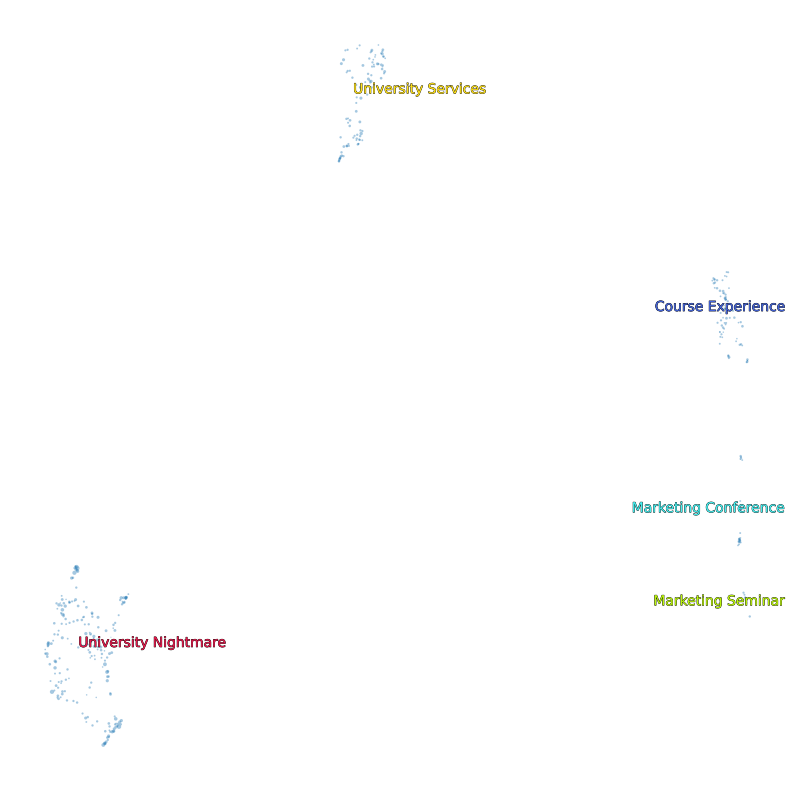

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y',palette=color_key ,alpha=0.4, sizes=(0.4, 10), size="Length")

texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                          ))

adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.show()

# Backup Saving

In [ ]:
!pip install safetensors

In [ ]:
import pickle

with open('/content/drive/MyDrive/BertTopic/rep_docs.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/BertTopic/reduced_embeddings.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
embedding_model = "BAAI/bge-small-en"
topic_model.save("/content/drive/MyDrive/BertTopic/final", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
!zip -r /content/llama2.zip /content/final

updating: content/final/ (stored 0%)
updating: content/final/ctfidf.safetensors (deflated 59%)
updating: content/final/topics.json (deflated 83%)
updating: content/final/ctfidf_config.json (deflated 69%)
updating: content/final/topic_embeddings.safetensors (deflated 7%)
updating: content/final/config.json (deflated 42%)


In [ ]:
!jupyter nbconvert --to markdown Topic_Modeling_with_Llama2.ipynb

[NbConvertApp] WARNING | pattern 'Topic_Modeling_with_Llama2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True